In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.lines import Line2D
%matplotlib inline
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from xmitgcm import open_mdsdataset

In [2]:
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/01_SVB_febTS_output/'
outdir2 = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL/01_noSVB_febTS/'

levels = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
          74, 79, 84, 89, 94, 99,]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], levels=levels)
ds2 = open_mdsdataset(outdir2, prefix=['eta','dynVars'], levels=levels)

In [3]:
nx = 512
ny = 612
nz = 100
nt = 720

In [4]:
depth = ds2.Depth[:]
LAT = ds2['YC'][:]
LON = ds2['XC'][:]-360
lat = ds2.YC[:,0].data
lon = ds2.XC[0,:].data-360

Z = ds2['Z'][:]
Zl = ds2['Zl'][:]

# No bay centers mask
hFacC = ds2['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth,0)
mask_dep = np.ma.getmask(dep_masked)
time = np.arange(0,720)*600

# bay centers mask
# centers mask
depthSVB = ds.Depth[:]
hFacCSVB = ds['hFacC'][:]
hfacSVB = np.ma.masked_values(hFacCSVB, 0)
maskSVB = np.ma.getmask(hfacSVB)
dep_maskedSVB = np.ma.masked_values(depthSVB,0)
mask_depSVB = np.ma.getmask(dep_maskedSVB)

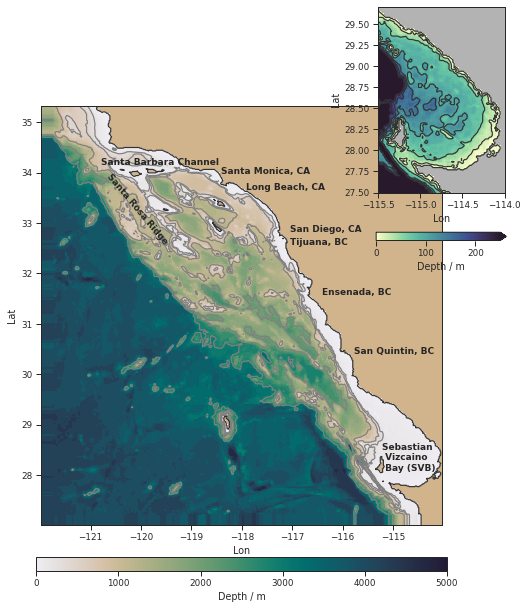

In [183]:
sns.set_style('ticks')
sns.set_context('paper')
fig = plt.figure(figsize=(7.6,9.2))

ax = fig.add_axes([0.1, 0.0, 0.75, 0.8])
ax.set_facecolor('tan')

pc = ax.pcolormesh(lon,lat,dep_maskedSVB,
                  vmin=0, vmax=5000, cmap=cmo.cm.rain)
cb = plt.colorbar(pc, ax=ax, label='Depth / m',pad=0.06, aspect=30,orientation='horizontal')

cn = ax.contour(lon,lat,dep_maskedSVB, colors=['0.5'], 
                levels=[250,500,1000,2000,3000])

ax.contour(lon,lat,depthSVB[:,:], levels=[0], colors='0.2')

ax.set_xlabel('Lon')
ax.set_ylabel('Lat')

ax.set_aspect(1)

ax.text(0.85,0.13,'Sebastian \n Vizcaino \n Bay (SVB)',fontsize=9, fontweight='bold',
        transform=ax.transAxes)
ax.text(0.78,0.41,'San Quintin, BC',fontsize=9, transform=ax.transAxes,fontweight='bold')
ax.text(0.7,0.55,'Ensenada, BC',fontsize=9, transform=ax.transAxes,fontweight='bold')
ax.text(0.62,0.67,'Tijuana, BC',fontsize=9, transform=ax.transAxes,fontweight='bold')
ax.text(0.62,0.7,'San Diego, CA',fontsize=9, transform=ax.transAxes,fontweight='bold')
ax.text(0.45,0.84,'Santa Monica, CA',fontsize=9, transform=ax.transAxes,fontweight='bold')
ax.text(0.51,0.8,'Long Beach, CA',fontsize=9, transform=ax.transAxes,fontweight='bold')
ax.text(0.15,0.86,'Santa Barbara Channel',fontsize=9, transform=ax.transAxes,
        fontweight='bold')
ax.text(0.16,0.67,'Santa Rosa Ridge',fontsize=9, transform=ax.transAxes,
        fontweight='bold',rotation=-50)

# ----------------------------------------
ax2 = fig.add_axes([0.7, 0.55, 0.28, 0.4])
ax2.set_facecolor('0.7')

pc2 = ax2.pcolormesh(lon,lat,dep_maskedSVB,
                     vmin=0, vmax=250, cmap=cmo.cm.deep)
cb2 = plt.colorbar(pc2,label='Depth / m', shrink=0.85, aspect=15,
                   extend='max', orientation='horizontal')
cn2 = ax2.contour(lon,lat,dep_maskedSVB, colors=['0.2'], 
                levels=[20,60,100,140,180,240])
ax2.contour(lon,lat,depthSVB[:,:], levels=[0], colors='0.2')

ax2.set_xlim(-115.5, -114)
ax2.set_ylim(27.5,29.7)

ax2.set_xlabel('Lon')
ax2.set_ylabel('Lat')

ax2.set_aspect(1)
plt.savefig('figure1.png')